In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import  DenseNet121
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model 
from keras.models import load_model 
from keras import backend as k 
import util 

In [ ]:
https://github.com/Noahbisht0/chestXray-dataset.git

In [ ]:
train_df = pd.read_csv("chestXray-dataset/nih/train-small.csv")
valid_df = pd.read_csv("chestXray-dataset/nih/valid-small.csv")
test_df = pd.read_csv("chestXray-dataset/nih/test.csv")
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [ ]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [ ]:
def check_for_leakage(df1,df2,patient_col):
  df1_patients_unique = set(df1[patient_col].values)
  df2_patients_unique = set(df2[patient_col].values)
  patients_in_both_group = list((df1_patients_unique).intersection(df2_patients_unique))
  leakage = len(patients_in_both_group) != 0 
  return leakage

In [ ]:
print("test case 1")
df1 = pd.DataFrame({'patient_id':[0,1,2]})
df2 = pd.DataFrame({'patient_id':[2,3,4]})
print(df1)
print(df2)
print(f"leakage output: {check_for_leakage(df1,df2,'patient_id')}")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [3, 4, 5]})
print(df1)
print(df2)
print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")

test case 1
   patient_id
0           0
1           1
2           2
   patient_id
0           2
1           3
2           4
leakage output: True
   patient_id
0           0
1           1
2           2
   patient_id
0           3
1           4
2           5
leakage output: False


In [ ]:
print("leakage between train and valid: {}".format(check_for_leakage(train_df,valid_df,'PatientId')))
print("leakage between train and test: {}".format(check_for_leakage(train_df,test_df,'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df,test_df,'PatientId')))

leakage between train and valid: True
leakage between train and test: False
leakage between valid and test: False


In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    batch = raw_train_generator.next()
    data_sample = batch[0]
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    image_generator.fit(data_sample)

    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
IMAGE_DIR = "chestXray-dataset/nih/images-small/"
train_generator = get_train_generator(train_df,IMAGE_DIR,'Image',labels)
valid_generator,test_generator = get_test_and_valid_generator(valid_df,test_df,train_df,IMAGE_DIR,"Image",labels)

getting train generator...
Found 32 validated image filenames.
getting train and valid generators...
Found 32 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 968 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1 validated image filenames.
Found 18 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 108 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 402 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


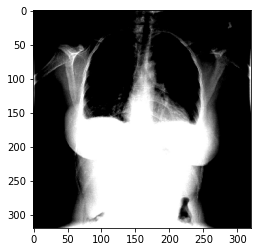

In [ ]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])

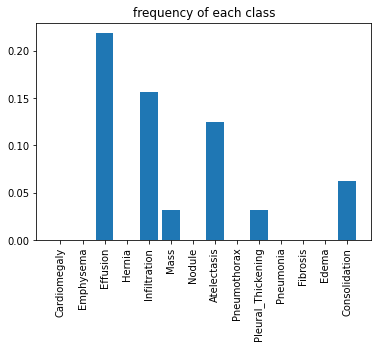

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=labels,height=np.mean(train_generator.labels,axis=0))
plt.title("frequency of each class")
plt.show()

In [ ]:
def compute_class_freqs(labels):
  N = labels.shape[0]
  positive_frequencies = np.sum(labels,axis=0) / N
  negative_frequencies = 1 - positive_frequencies
  return positive_frequencies,negative_frequencies

In [ ]:
labels_matrix = np.array( [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]])
print(labels_matrix)
test_pos_freq,test_neg_freq = compute_class_freqs(labels_matrix)
print(f"pos freq {test_pos_freq}")
print(f"neg freq {test_neg_freq}")

[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freq [0.8 0.4 0.8]
neg freq [0.2 0.6 0.2]


In [ ]:
freq_pos,freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.     , 0.     , 0.21875, 0.     , 0.15625, 0.03125, 0.     ,
       0.125  , 0.     , 0.03125, 0.     , 0.     , 0.     , 0.0625 ])

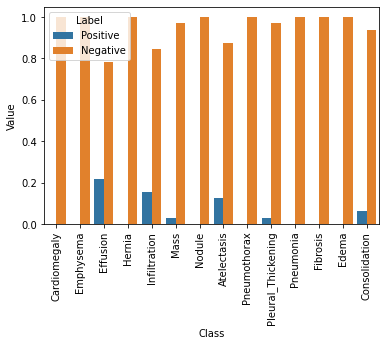

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [ ]:
pos_weights = freq_neg 
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

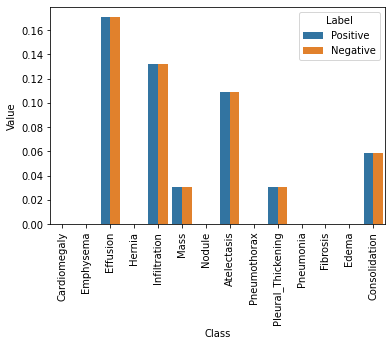

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [ ]:

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):

        loss = 0.0

        for i in range(len(pos_weights)):
            loss_pos = -1 * k.mean(pos_weights[i] * y_true[:, i] * k.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * k.mean(neg_weights[i] * (1 - y_true[:, i]) * k.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss
    return weighted_loss

In [ ]:
y_true = k.constant(np.array(
        [[1, 1, 1],
         [1, 1, 0],
         [0, 1, 0],
         [1, 0, 1]]
    ))
print(y_true)

w_p = np.array([0.25, 0.25, 0.5])
w_n = np.array([0.75, 0.75, 0.5])
print(w_p)
print(w_n)

y_pred_1 = k.constant(0.7*np.ones(y_true.shape))
print(y_pred_1)

y_pred_2 = k.constant(0.3*np.ones(y_true.shape))
print(y_pred_2)

L = get_weighted_loss(w_p, w_n, epsilon=1)
L1 = L(y_true, y_pred_1)
L2 = L(y_true, y_pred_2)
print(f"\nL(y_pred_1)= {L1:.4f}, L(y_pred_2)= {L2:.4f}")
print(f"Difference is L1 - L2 = {L1 - L2:.4f}")

tf.Tensor(
[[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]], shape=(4, 3), dtype=float32)
[0.25 0.25 0.5 ]
[0.75 0.75 0.5 ]
tf.Tensor(
[[0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]], shape=(4, 3), dtype=float32)
tf.Tensor(
[[0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]], shape=(4, 3), dtype=float32)

L(y_pred_1)= -0.4956, L(y_pred_2)= -0.4956
Difference is L1 - L2 = 0.0000


In [ ]:
base_model = DenseNet121(weights="./nih/densenet.hdf5",include_top=False)
x = base_model.output 
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(labels),activation="sigmoid")(x)
model = Model(inputs=base_model.input,outputs=predictions)
model.compile(optimizer="adam",loss=get_weighted_loss(pos_weights,neg_weights))